In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
# Data used for training and testing
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT']
stock = yf.download(tickers, start="2010-01-01", end="2020-01-01").stack()
stock.index.names = ['date', 'ticker']
stock.columns = stock.columns.str.lower()

# Data used purely for backtesting.
backtest_stocks = yf.download(tickers, start="2020-01-01", end="2025-01-01").stack()
backtest_stocks.index.names = ['date', 'ticker']
backtest_stocks.columns = stock.columns.str.lower()

backtest_stocks


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


Price                   close        high         low        open     volume
date       ticker                                                           
2020-01-02 AAPL     72.716072   72.776598   71.466812   71.721019  135480400
           AMZN     94.900497   94.900497   93.207497   93.750000   80580000
           GOOG     68.123726   68.162086   66.837348   66.837348   28132000
           MSFT    153.630722  153.735936  151.440376  151.870792   22622100
2020-01-03 AAPL     72.009117   72.771745   71.783962   71.941328  146322800
...                       ...         ...         ...         ...        ...
2024-12-30 MSFT    424.829987  427.549988  421.899994  426.059998   13158700
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200
           MSFT    421.500000  426.730011  420.660004  426.100006   13246500

[5032 rows x 5 columns]

In [5]:
''' Adding only three features due the size of the dataset I am uisng. However, For this dataset using just SMA and RSI can be sufficient. '''

# Calculating the Garman-Klass Volatility to capture volatility.
stock['gk_volatility'] = np.sqrt((np.log(stock['high'] / stock['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(stock['close'] / stock['open']) ** 2))

# Calculating Relative Strength Index (RSI) to capture momentum.
delta = stock['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
stock['rsi'] = 100 - (100 / (1 + rs))

# Bollinger Bands to capture price extremes.
window = 20
stock['bb_middle'] = stock['close'].rolling(window=window).mean()
stock['bb_Upper'] = stock['bb_middle'] + (2 * stock['close'].rolling(window=window).std())
stock['bb_Lower'] = stock['bb_middle'] - (2 * stock['close'].rolling(window=window).std())

stock = stock.dropna()
stock

Price                   close        high         low        open     volume  \
date       ticker                                                              
2010-01-08 MSFT     23.082361   23.247988   22.766164   22.796279   51197400   
2010-01-11 AAPL      6.322967    6.409937    6.273011    6.403918  462229600   
           AMZN      6.515500    6.640000    6.460500    6.631000  175588000   
           GOOG     14.918031   15.001169   14.742571   15.001169  289597429   
           MSFT     22.788742   23.157638   22.675815   23.119995   68754700   
...                       ...         ...         ...         ...        ...   
2019-12-30 MSFT    150.732513  152.100295  149.909935  152.071602   16348400   
2019-12-31 AAPL     71.093971   71.101234   70.094079   70.193342  100805600   
           AMZN     92.391998   92.663002   91.611504   92.099998   50130000   
           GOOG     66.611664   66.660492   66.216333   66.267404   19236000   
           MSFT    150.837769  150.904730  149.642162  149.948244   18369400   

Price              gk_volatility        rsi  bb_middle    bb_Upper   bb_Lower  
date       ticker                                                              
2010-01-08 MSFT         0.012618  56.985506  12.838801   27.052607  -1.375005  
2010-01-11 AAPL         0.013062  46.335453  12.832933   27.057954  -1.392089  
           AMZN         0.016008  42.847530  12.823958   27.065502  -1.417586  
           GOOG         0.011801  53.936810  12.792142   27.010827  -1.426544  
           MSFT         0.011857  56.946100  12.766545   26.907206  -1.374116  
...                          ...        ...        ...         ...        ...  
2019-12-30 MSFT         0.008659  54.094116  94.918036  164.353455  25.482617  
2019-12-31 AAPL         0.006243  50.258035  95.034850  164.292595  25.777105  
           AMZN         0.007826  46.088097  95.171950  164.395659  25.948240  
           GOOG         0.003461  49.740263  95.142506  164.416793  25.868218  
           MSFT         0.004667  53.829038  95.156376  164.477478  25.835274  

[10045 rows x 10 columns]

In [6]:
# prepping data.
stock['return'] = stock['close'].pct_change()
stock['signal'] = (stock['return'].shift(-1) > 0).astype(int) # Target => 1(if next day's return is _+ve):buy and 0:sell
stock = stock.dropna()

stock

Price                   close        high         low        open     volume  \
date       ticker                                                              
2010-01-11 AAPL      6.322967    6.409937    6.273011    6.403918  462229600   
           AMZN      6.515500    6.640000    6.460500    6.631000  175588000   
           GOOG     14.918031   15.001169   14.742571   15.001169  289597429   
           MSFT     22.788742   23.157638   22.675815   23.119995   68754700   
2010-01-12 AAPL      6.251041    6.312734    6.211920    6.295279  594459600   
...                       ...         ...         ...         ...        ...   
2019-12-30 MSFT    150.732513  152.100295  149.909935  152.071602   16348400   
2019-12-31 AAPL     71.093971   71.101234   70.094079   70.193342  100805600   
           AMZN     92.391998   92.663002   91.611504   92.099998   50130000   
           GOOG     66.611664   66.660492   66.216333   66.267404   19236000   
           MSFT    150.837769  150.904730  149.642162  149.948244   18369400   

Price              gk_volatility        rsi  bb_middle    bb_Upper   bb_Lower  \
date       ticker                                                               
2010-01-11 AAPL         0.013062  46.335453  12.832933   27.057954  -1.392089   
           AMZN         0.016008  42.847530  12.823958   27.065502  -1.417586   
           GOOG         0.011801  53.936810  12.792142   27.010827  -1.426544   
           MSFT         0.011857  56.946100  12.766545   26.907206  -1.374116   
2010-01-12 AAPL         0.010506  46.447901  12.756524   26.916299  -1.403252   
...                          ...        ...        ...         ...        ...   
2019-12-30 MSFT         0.008659  54.094116  94.918036  164.353455  25.482617   
2019-12-31 AAPL         0.006243  50.258035  95.034850  164.292595  25.777105   
           AMZN         0.007826  46.088097  95.171950  164.395659  25.948240   
           GOOG         0.003461  49.740263  95.142506  164.416793  25.868218   
           MSFT         0.004667  53.829038  95.156376  164.477478  25.835274   

Price                return  signal  
date       ticker                    
2010-01-11 AAPL   -0.726069       1  
           AMZN    0.030450       1  
           GOOG    1.289622       1  
           MSFT    0.527597       0  
2010-01-12 AAPL   -0.725696       1  
...                     ...     ...  
2019-12-30 MSFT    1.264345       0  
2019-12-31 AAPL   -0.528343       1  
           AMZN    0.299576       0  
           GOOG   -0.279032       1  
           MSFT    1.264435       0  

[10044 rows x 12 columns]

In [7]:
# defining Feature list and Target. 
X = stock[['gk_volatility', 'rsi', 'bb_middle', 'bb_Upper', 'bb_Lower']]
y = stock['signal']

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [8]:
# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9193628670980587


In [10]:
''' Apply model to backtesting data: Adding idential features to generate predictions on unseen data.'''


features = ['gk_volatility', 'rsi', 'bb_middle', 'bb_Upper', 'bb_Lower']

# Calculating the Garman-Klass Volatility to capture volatility.
backtest_stocks['gk_volatility'] = np.sqrt((np.log(backtest_stocks['high'] / backtest_stocks['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(backtest_stocks['close'] / backtest_stocks['open']) ** 2))

# Calculating Relative Strength Index (RSI) to capture momentum.
delta = backtest_stocks['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
backtest_stocks['rsi'] = 100 - (100 / (1 + rs))

# Bollinger Bands to capture price extremes.
window = 20
backtest_stocks['bb_middle'] = backtest_stocks['close'].rolling(window=window).mean()
backtest_stocks['bb_Upper'] = backtest_stocks['bb_middle'] + (2 * backtest_stocks['close'].rolling(window=window).std())
backtest_stocks['bb_Lower'] = backtest_stocks['bb_middle'] - (2 * backtest_stocks['close'].rolling(window=window).std())

backtest_stocks = backtest_stocks.dropna()
backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
backtest_stocks['return'] = backtest_stocks['close'].pct_change()

backtest_stocks

C:\Users\harsi\AppData\Local\Temp\ipykernel_7744\734503420.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
C:\Users\harsi\AppData\Local\Temp\ipykernel_7744\734503420.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['return'] = backtest_stocks['close'].pct_change()


Price                   close        high         low        open     volume  \
date       ticker                                                              
2020-01-08 MSFT    153.123734  153.802845  151.076855  152.014207   27746500   
2020-01-09 AAPL     74.962791   75.156472   74.132375   74.384158  170108400   
           AMZN     95.052498   95.890999   94.790001   95.494499   63346000   
           GOOG     70.737335   71.110993   70.261042   70.774205   30018000   
           MSFT    155.036682  155.161030  154.022810  154.797561   21385000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    424.829987  427.549988  421.899994  426.059998   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    421.500000  426.730011  420.660004  426.100006   13246500   

Price              gk_volatility        rsi   bb_middle    bb_Upper  \
date       ticker                                                     
2020-01-08 MSFT         0.011810  54.031326   97.137455  165.529786   
2020-01-09 AAPL         0.008422  50.454802   97.249791  165.480416   
           AMZN         0.007640  46.090899   97.257391  165.486948   
           GOOG         0.008496  49.862264   97.388072  165.392321   
           MSFT         0.005117  54.092680   97.458370  165.709875   
...                          ...        ...         ...         ...   
2024-12-30 MSFT         0.009233  55.734555  277.526195  467.666323   
2024-12-31 AAPL         0.009611  51.420772  277.283961  467.557274   
           AMZN         0.009331  43.291322  277.000461  467.617987   
           GOOG         0.011893  47.704469  276.722961  467.852526   
           MSFT         0.007557  55.763360  276.035461  464.848954   

Price               bb_Lower  Predicted_Signal    return  
date       ticker                                         
2020-01-08 MSFT    28.745125                 0       NaN  
2020-01-09 AAPL    29.019167                 1 -0.510443  
           AMZN    29.027835                 0  0.267996  
           GOOG    29.383822                 1 -0.255808  
           MSFT    29.206864                 0  1.191724  
...                      ...               ...       ...  
2024-12-30 MSFT    87.386067                 0  1.204733  
2024-12-31 AAPL    87.010647                 1 -0.411188  
           AMZN    86.382934                 0 -0.122949  
           GOOG    85.593395                 0 -0.131957  
           MSFT    87.221968                 0  1.213295  

[5013 rows x 12 columns]

In [11]:
# Comparission and plotting 
# Convert the index to datetime if not already
#backtest_stocks.index = pd.to_datetime(backtest_stocks.index)

# calculating the returns from the model: if signal = 1 we take the return(loss or gain) for the day, else we do nothing. 
# shifting by one to ensure that only past predictions affect the future.
backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']

# This represents the compunded growth of investing 1 dollar, following the models's predictions.
backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()

# This represents the compunded growth of investing 1 dollar, following the buy-hold statergy.
backtest_stocks['Cumulative_Stock_Return'] = (1 + backtest_stocks['return']).cumprod()
backtest_stocks




C:\Users\harsi\AppData\Local\Temp\ipykernel_7744\2916122683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']
C:\Users\harsi\AppData\Local\Temp\ipykernel_7744\2916122683.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()
C:\Users\harsi\AppData\Local\Temp\ipykernel_7744\2916122683.py:13: SettingWith

Price                   close        high         low        open     volume  \
date       ticker                                                              
2020-01-08 MSFT    153.123734  153.802845  151.076855  152.014207   27746500   
2020-01-09 AAPL     74.962791   75.156472   74.132375   74.384158  170108400   
           AMZN     95.052498   95.890999   94.790001   95.494499   63346000   
           GOOG     70.737335   71.110993   70.261042   70.774205   30018000   
           MSFT    155.036682  155.161030  154.022810  154.797561   21385000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    424.829987  427.549988  421.899994  426.059998   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    421.500000  426.730011  420.660004  426.100006   13246500   

Price              gk_volatility        rsi   bb_middle    bb_Upper  \
date       ticker                                                     
2020-01-08 MSFT         0.011810  54.031326   97.137455  165.529786   
2020-01-09 AAPL         0.008422  50.454802   97.249791  165.480416   
           AMZN         0.007640  46.090899   97.257391  165.486948   
           GOOG         0.008496  49.862264   97.388072  165.392321   
           MSFT         0.005117  54.092680   97.458370  165.709875   
...                          ...        ...         ...         ...   
2024-12-30 MSFT         0.009233  55.734555  277.526195  467.666323   
2024-12-31 AAPL         0.009611  51.420772  277.283961  467.557274   
           AMZN         0.009331  43.291322  277.000461  467.617987   
           GOOG         0.011893  47.704469  276.722961  467.852526   
           MSFT         0.007557  55.763360  276.035461  464.848954   

Price               bb_Lower  Predicted_Signal    return  strategy_return  \
date       ticker                                                           
2020-01-08 MSFT    28.745125                 0       NaN              NaN   
2020-01-09 AAPL    29.019167                 1 -0.510443        -0.000000   
           AMZN    29.027835                 0  0.267996         0.267996   
           GOOG    29.383822                 1 -0.255808        -0.000000   
           MSFT    29.206864                 0  1.191724         1.191724   
...                      ...               ...       ...              ...   
2024-12-30 MSFT    87.386067                 0  1.204733         0.000000   
2024-12-31 AAPL    87.010647                 1 -0.411188        -0.000000   
           AMZN    86.382934                 0 -0.122949        -0.122949   
           GOOG    85.593395                 0 -0.131957        -0.000000   
           MSFT    87.221968                 0  1.213295         0.000000   

Price              Cumulative_Strategy_Return  Cumulative_Stock_Return  
date       ticker                                                       
2020-01-08 MSFT                           NaN                      NaN  
2020-01-09 AAPL                  1.000000e+00                 0.489557  
           AMZN                  1.267996e+00                 0.620756  
           GOOG                  1.267996e+00                 0.461962  
           MSFT                  2.779096e+00                 1.012493  
...                                       ...                      ...  
2024-12-30 MSFT                 1.059674e+233                 2.774423  
2024-12-31 AAPL                 1.059674e+233                 1.633613  
           AMZN                 9.293883e+232                 1.432763  
           GOOG                 9.293883e+232                 1.243700  
           MSFT                 9.293883e+232                 2.752676  

[5013 rows x 15 columns]

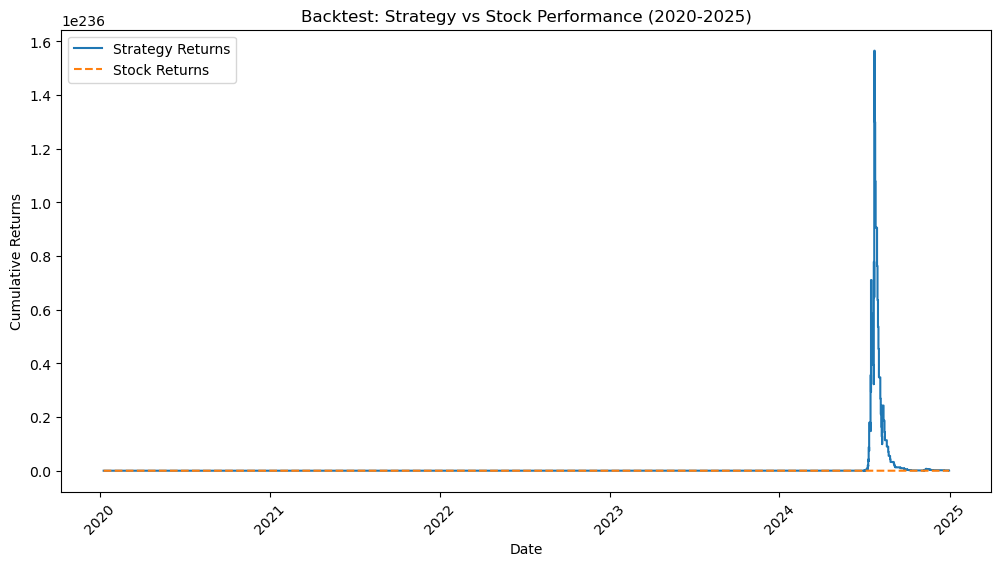

In [12]:
index_tuples = backtest_stocks.index.tolist()
dates = [item[0] for item in index_tuples]
tickers = [item[1] for item in index_tuples]

plt.figure(figsize=(12, 6))
plt.plot(dates, backtest_stocks['Cumulative_Strategy_Return'], label='Strategy Returns', linestyle='-')
plt.plot(dates, backtest_stocks['Cumulative_Stock_Return'], label='Stock Returns', linestyle='--')
plt.legend()
plt.title('Backtest: Strategy vs Stock Performance (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.show()